# Project 1: Reactor Design Adapted from Pyomo — Optimization Modeling in Python
**Prepared by:** Zhicheng Lu (zlu3@nd.edu, 2024) & Shammah Lilonfe (slilonfe@nd.edu, 2024) at the University of Notre Dame.

Chemical reactors are often the most important unit operations in a chemical plant. Reactors come in many forms, however two of the most common idealizations are the continuously stirred tank reactor (CSTR) and the plug flow reactor. The CSTR is often used in modeling studies, and it can be effectively modeled as a lumped parameter system. In this example, we will consider the following reaction scheme known as the Van de Vusse reaction:

$$
\text{A} \xrightarrow{k_1} \text{B} \xrightarrow{k_2} \text{C}
$$


$$
2\text{A} \xrightarrow{k_3} \text{D}
$$

A diagram of the system is shown in figure below, where F is the volumetric flowrate. The reactor is assumed to be filled to a constant volume, and the mixture is assumed to have constant density, so the volumetric flowrate into the reactor is equal to the volumetric flowrate out of the reactor. Since the reactor is assumed to be wellmixed, the concentrations in the reactor are equivalent to the concentrations of each component flowing out of the reactor, given by $C_A$, $C_B$, $C_C$, and $C_D$.

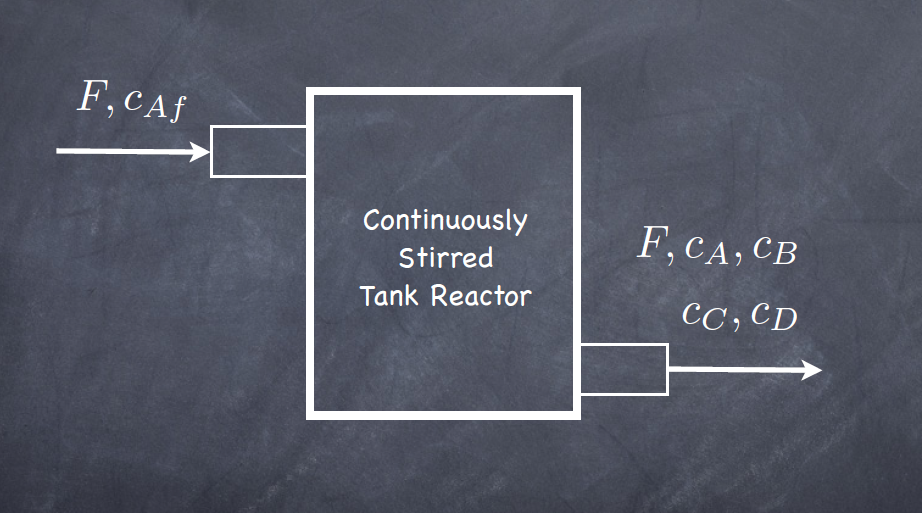

This example (both text and figure) was taken from Hart et al (2017).

## How this Work Goes Beyond Reference Material
In this project, species C is the desired product, and we are considering the dynamic state of the system (most often, industrial operations are dynamic). The goal of this work is to determine the volume of the reactor that will maximize the concentration of species C in the effluent after 10 minutes. Furthermore, for economic reasons, the reactor volume shouldn't exceed $100m^3$.

The mole balance for each of the species in this system under dynamic state is given by:

$$\begin{align*}
&\frac{dC_A}{dt}=\frac{F}{V}C_{Af}-\frac{F}{V}C_A-k_1C_A-2k_3C_A^2 \\
& \frac{dC_B}{dt}=-\frac{F}{V}C_B+k_1C_A-k_2C_B\\
& \frac{dC_C}{dt}=-\frac{F}{V}C_C+k_2C_B \\
& \frac{dC_D}{dt}=-\frac{F}{V}C_D+k_3C_A^2
\end{align*}$$

Where $C_A$, $C_B$, $C_C$ and $C_D$ are the concentrations of species A, B, C and D, respectively. $F$ is the feed flow rate, $C_{Af}$ is the concentration of species A in the feed, $k_1$, $k_2$ and $k_3$ are the rate constants of reaction 1 (species A to B), reaction 2 (species B to C) and reaction 3 (species A to D), respectively.

The data for the system are:
$$C_{Af}=10^4\frac{mol}{m^3},\quad{k_1=\frac{5}{6}min^{-1}},\quad{k_2=\frac{5}{3}min^{-1}},\quad{k_3=\frac{1}{6000}\frac{m^3}{mol.min}},\quad{F=1\frac{m^3}{min}}$$

This was adapted from Hart et al (2017).

In [10]:
# Importing the libraries needed for the project
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

# Importing packages to be used in this project
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt

--2024-10-08 20:14:36--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py.2’

helper.py.2         100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-10-08 20:14:36 (33.4 MB/s) - ‘helper.py.2’ saved [6493/6493]

idaes was found! No need to install.


## Optimization Model Formulation

Mathematically, we want to solve the following optimal reactor volume problem:

$$\begin{align*}
\max_{V} \quad & C_C(t=10) \\
\mathrm{s.t.} \quad & \frac{dC_A}{dt}=\frac{F}{V}C_{Af}-\frac{F}{V}C_A-k_1C_A-2k_3C_A^2 \\
& \frac{dC_B}{dt}=-\frac{F}{V}C_B+k_1C_A-k_2C_B \\
& \frac{dC_C}{dt}=-\frac{F}{V}C_C+k_2C_B \\
& \frac{dC_D}{dt}=-\frac{F}{V}C_D+k_3C_A^2 \\
& C_A(t=0) = 10000, ~~ C_B(t=0) = 0 \\
& C_C(t=0) = 0, ~~ C_D(t=0) = 0 \\
& V \leq 100,\quad \forall t \in [0, 10]
\end{align*}$$

Here "s.t." means "subject to", i.e., the constraints.

## Degrees of Freedom Analysis
From the optimization model formulated above:\
Number of state variables = 4 \
Number of equality constraints = 4 \
Therefore, the degrees of freedom = 4 - 4 = 0



## Pyomo Implementation
We can use `Pyomo.dae` to automatically formulate the collocation equations (i.e., add constraints that numerically integrate the ODE model).

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

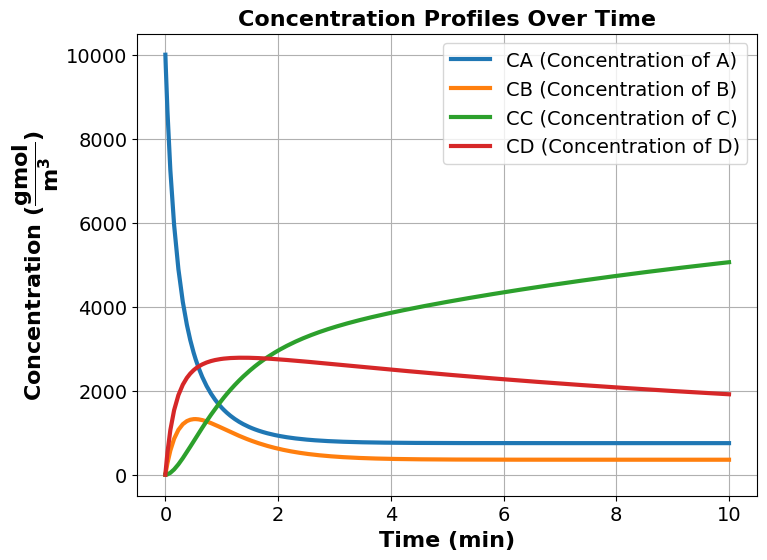

In [11]:
# function that creates pyomo model for the reaction system
def create_model(F, CAF, k1, k2, k3):
    """Creates reactor model
    Argument:
        F: feed volumetric flow rate in m^3/min
        CAF: feed concentration of A, gmol/m^3
        k1: rate constant for A to B, min^-1
        k2: rate constant for B to C, min^-1
        k3: rate constant for 2A to D, m^3/gmol/min

    Returns:
        model: pyomo model"""

    # Create a Pyomo model
    model = ConcreteModel()

    # Define time as a continuous set
    model.t = ContinuousSet(bounds=(0, 10))  # time from 0 to 10 minutes

    # Define variables for concentrations and reactor volume
    model.CA = Var(model.t, within=NonNegativeReals)
    model.CB = Var(model.t, within=NonNegativeReals)
    model.CC = Var(model.t, within=NonNegativeReals)
    model.CD = Var(model.t, within=NonNegativeReals)
    model.V = Var(within=NonNegativeReals, bounds=(0.1, 100), initialize=1)


    # Define derivatives of concentrations
    model.dCA_dt = DerivativeVar(model.CA, wrt=model.t)
    model.dCB_dt = DerivativeVar(model.CB, wrt=model.t)
    model.dCC_dt = DerivativeVar(model.CC, wrt=model.t)
    model.dCD_dt = DerivativeVar(model.CD, wrt=model.t)

    # CA differential equation
    def ca_rate_ode(m, t):
        return m.dCA_dt[t] == (F/m.V)*CAF - (F/m.V)*m.CA[t] - k1*m.CA[t] - 2*k3*m.CA[t]**2
    model.CA_ode = Constraint(model.t, rule=ca_rate_ode)

    # CB differential equation
    def cb_rate_ode(m, t):
        return m.dCB_dt[t] == -(F/m.V)*m.CB[t] + k1*m.CA[t] - k2*m.CB[t]
    model.CB_ode = Constraint(model.t, rule=cb_rate_ode)

    # CC differential equation
    def cc_rate_ode(m, t):
        return m.dCC_dt[t] == -(F/m.V)*m.CC[t] + k2*m.CB[t]
    model.CC_ode = Constraint(model.t, rule=cc_rate_ode)

    # CD differential equation
    def cd_rate_ode(m, t):
        return m.dCD_dt[t] == -(F/m.V)*m.CD[t] + k3*m.CA[t]**2
    model.CD_ode = Constraint(model.t, rule=cd_rate_ode)

    # Initial conditions
    def init_conditions(m):
        yield m.CA[0] == CAF
        yield m.CB[0] == 0
        yield m.CC[0] == 0
        yield m.CD[0] == 0
    model.init_conditions = ConstraintList(rule=init_conditions)

    # Objective: Maximize concentration of C at t = 10 minutes
    def objective_function(m):
        return m.CC[10]
    model.objective = Objective(rule=objective_function, sense=maximize)

    return model

# Parameters from data
conc_A_feed = 10000  # gmol/m^3
k1 = 5/6  # min^-1
k2 = 5/3  # min^-1
k3 = 1/6000  # m^3/gmol/min
feed_flowrate = 1 # m^3/min

# reactor model object
reactor_model = create_model(feed_flowrate, conc_A_feed, k1, k2, k3)

# Discretize the model using Collocation
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(reactor_model, nfe=20, ncp=10)

# Solve the model
solver = SolverFactory('ipopt')
results = solver.solve(reactor_model, tee=True)

# print optimal reactor volume
print(f"Optimal reactor volume is: {value(reactor_model.V)} m^3")

# Extract the concentration of C at t = 10 minutes
optimal_concentration_C = value(reactor_model.CC[10])
print(f"Maximum Concentration of C at optimal reactor volume is: {optimal_concentration_C} gmol/m^3")


# Extract results for plotting
time = [i for i in reactor_model.t]
CA_values = [value(reactor_model.CA[t]) for t in reactor_model.t]
CB_values = [value(reactor_model.CB[t]) for t in reactor_model.t]
CC_values = [value(reactor_model.CC[t]) for t in reactor_model.t]
CD_values = [value(reactor_model.CD[t]) for t in reactor_model.t]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(time, CA_values, label='CA (Concentration of A)')
plt.plot(time, CB_values, label='CB (Concentration of B)')
plt.plot(time, CC_values, label='CC (Concentration of C)')
plt.plot(time, CD_values, label='CD (Concentration of D)')
plt.xlabel('Time (min)', fontsize=16,fontweight='bold')
plt.ylabel('Concentration ($\mathbf{\dfrac{gmol}{m^3}}$)', fontsize=16,fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Concentration Profiles Over Time', fontsize=16,fontweight='bold')
plt.legend()
plt.grid()
plt.show()

## Reference
Hart, W. E., Laird, C. D., Watson, J. P., Woodruff, D. L., Hackebeil, G. A., Nicholson, B. L., & Siirola, J. D. (2017). Pyomo-optimization modeling in python (Vol. 67, p. 277). Berlin: Springer.

